22:07:39 - cmdstanpy - INFO - Chain [1] start processing
22:07:39 - cmdstanpy - INFO - Chain [1] done processing


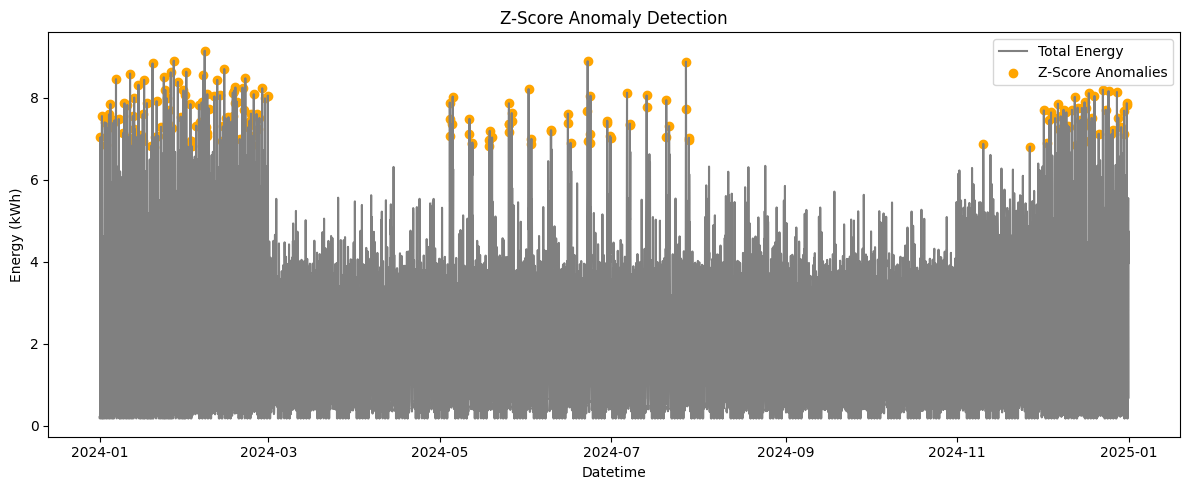

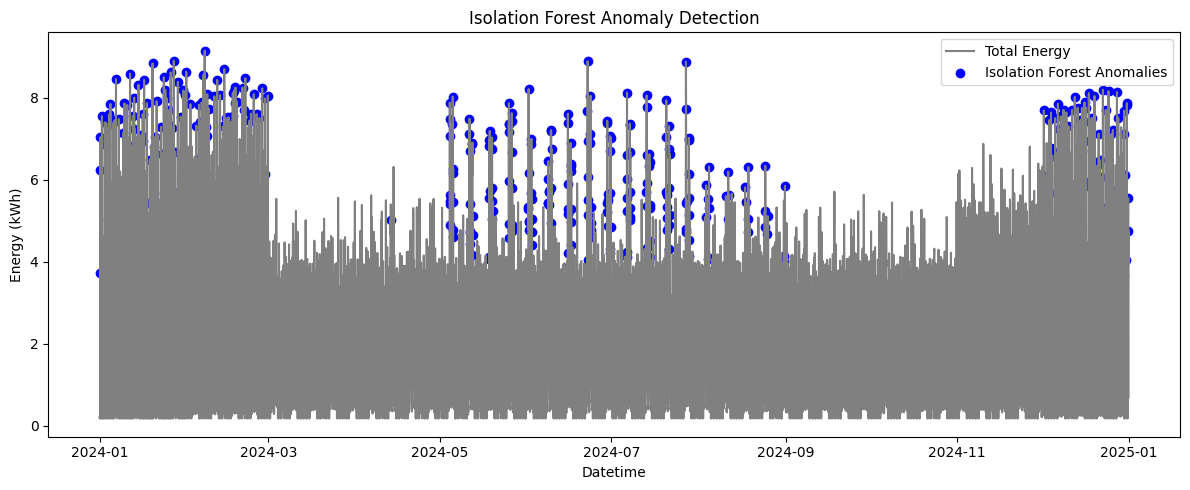

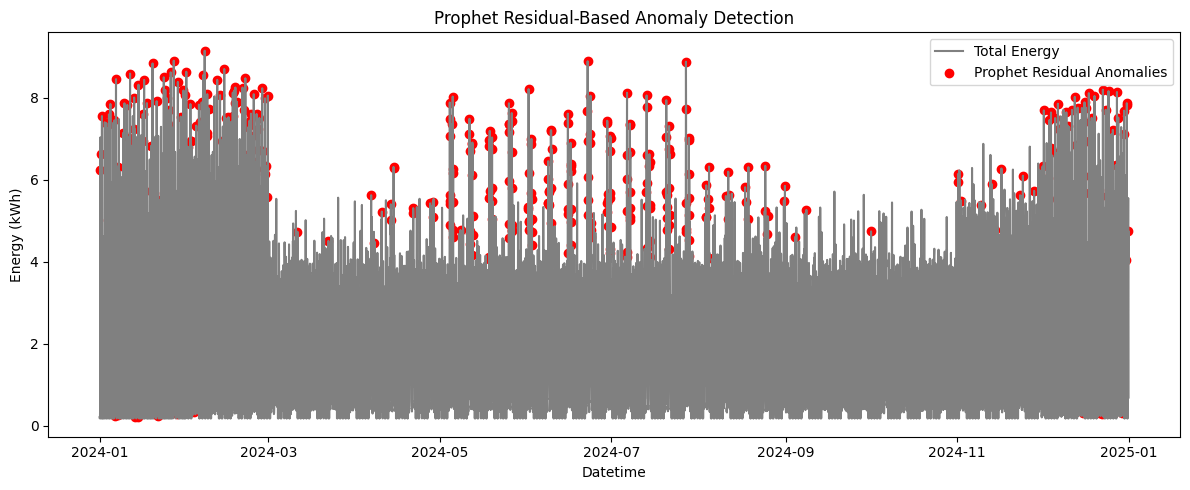

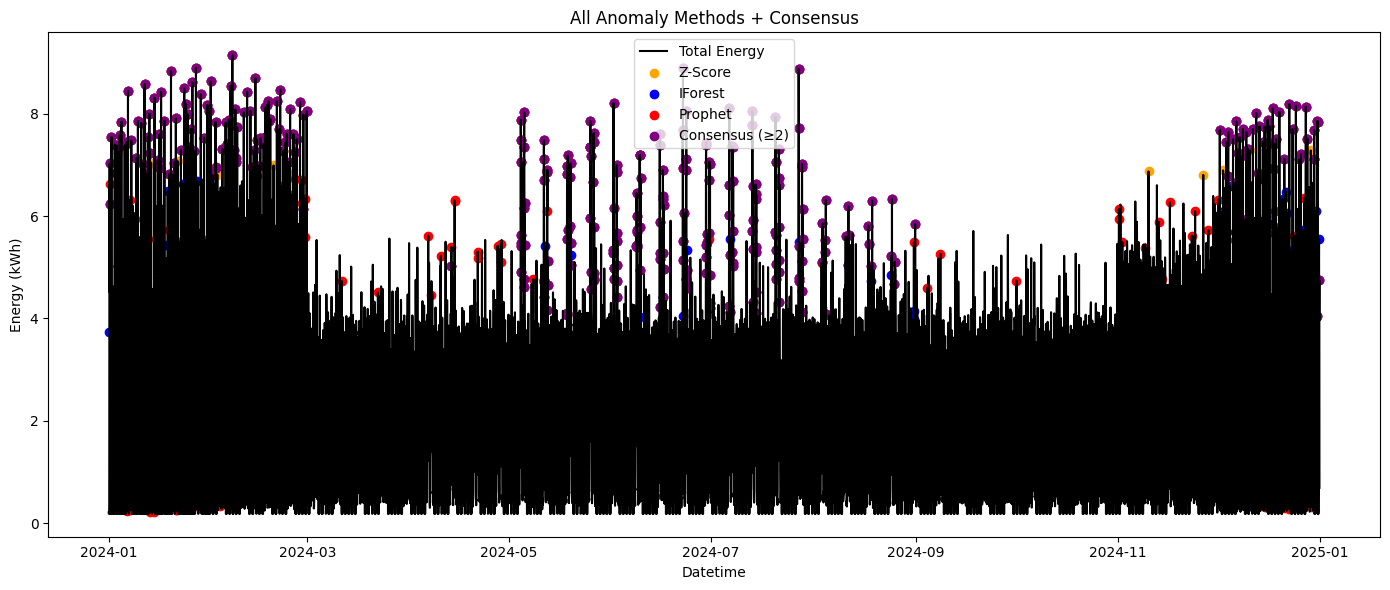

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from scipy.stats import zscore
from prophet import Prophet

# === Load your Excel file ===
df = pd.read_excel(r'C:\Users\onush\OneDrive\Documents\IOT\Combined.xlsx')

# === Setup columns ===
datetime_col = 'Datetime'
target_col = 'Total_Energy_kWh'
feature_cols = [
    'LivingRoom_Energy_kWh', 'Bathroom1_Energy_kWh', 'Bathroom2_Energy_kWh',
    'Bedroom1_Energy_kWh', 'Bedroom2_Energy_kWh', 'Kitchen_Energy_kWh'
]

# === Clean and prepare the data ===
df_clean = df.dropna(subset=[datetime_col, target_col] + feature_cols).copy()
df_clean[datetime_col] = pd.to_datetime(df_clean[datetime_col])

# === 1. Z-Score Anomaly Detection ===
df_clean['Z_Score'] = zscore(df_clean[target_col])
df_clean['ZScore_Anomaly'] = df_clean['Z_Score'].apply(lambda x: 1 if abs(x) > 2.5 else 0)

# === 2. Isolation Forest Detection ===
iso = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
df_clean['IForest_Anomaly'] = iso.fit_predict(df_clean[feature_cols])
df_clean['IForest_Anomaly'] = df_clean['IForest_Anomaly'].apply(lambda x: 1 if x == -1 else 0)

# === 3. Prophet Forecast + Residual-Based Detection ===
df_prophet = df_clean[[datetime_col, target_col]].rename(columns={datetime_col: 'ds', target_col: 'y'})
model = Prophet()
model.fit(df_prophet)
forecast = model.predict(model.make_future_dataframe(periods=0, freq='h'))

# Compare actual vs predicted
merged = forecast.merge(df_prophet, on='ds', how='left')
merged['error'] = merged['y'] - merged['yhat']
merged['z_error'] = zscore(merged['error'].fillna(0))
merged['Prophet_Anomaly'] = merged['z_error'].apply(lambda x: 1 if abs(x) > 2.0 else 0)

# Merge Prophet Anomalies into df_clean
df_clean = df_clean.merge(merged[['ds', 'Prophet_Anomaly']], left_on=datetime_col, right_on='ds', how='left').drop(columns='ds')
df_clean['Consensus_Anomaly'] = df_clean[['ZScore_Anomaly', 'IForest_Anomaly', 'Prophet_Anomaly']].sum(axis=1) >= 2

# === Plot 1: Z-Score Anomalies ===
plt.figure(figsize=(12, 5))
plt.plot(df_clean[datetime_col], df_clean[target_col], label='Total Energy', color='gray')
plt.scatter(df_clean[df_clean['ZScore_Anomaly'] == 1][datetime_col],
            df_clean[df_clean['ZScore_Anomaly'] == 1][target_col],
            color='orange', label='Z-Score Anomalies')
plt.title('Z-Score Anomaly Detection')
plt.xlabel('Datetime'); plt.ylabel('Energy (kWh)')
plt.legend(); plt.tight_layout(); plt.show()

# === Plot 2: Isolation Forest Anomalies ===
plt.figure(figsize=(12, 5))
plt.plot(df_clean[datetime_col], df_clean[target_col], label='Total Energy', color='gray')
plt.scatter(df_clean[df_clean['IForest_Anomaly'] == 1][datetime_col],
            df_clean[df_clean['IForest_Anomaly'] == 1][target_col],
            color='blue', label='Isolation Forest Anomalies')
plt.title('Isolation Forest Anomaly Detection')
plt.xlabel('Datetime'); plt.ylabel('Energy (kWh)')
plt.legend(); plt.tight_layout(); plt.show()

# === Plot 3: Prophet Residual Anomalies ===
plt.figure(figsize=(12, 5))
plt.plot(df_clean[datetime_col], df_clean[target_col], label='Total Energy', color='gray')
plt.scatter(df_clean[df_clean['Prophet_Anomaly'] == 1][datetime_col],
            df_clean[df_clean['Prophet_Anomaly'] == 1][target_col],
            color='red', label='Prophet Residual Anomalies')
plt.title('Prophet Residual-Based Anomaly Detection')
plt.xlabel('Datetime'); plt.ylabel('Energy (kWh)')
plt.legend(); plt.tight_layout(); plt.show()

# === Plot 4: All Methods Combined (Consensus) ===
plt.figure(figsize=(14, 6))
plt.plot(df_clean[datetime_col], df_clean[target_col], label='Total Energy', color='black')
plt.scatter(df_clean[df_clean['ZScore_Anomaly'] == 1][datetime_col],
            df_clean[df_clean['ZScore_Anomaly'] == 1][target_col], color='orange', label='Z-Score')
plt.scatter(df_clean[df_clean['IForest_Anomaly'] == 1][datetime_col],
            df_clean[df_clean['IForest_Anomaly'] == 1][target_col], color='blue', label='IForest')
plt.scatter(df_clean[df_clean['Prophet_Anomaly'] == 1][datetime_col],
            df_clean[df_clean['Prophet_Anomaly'] == 1][target_col], color='red', label='Prophet')
plt.scatter(df_clean[df_clean['Consensus_Anomaly']][datetime_col],
            df_clean[df_clean['Consensus_Anomaly']][target_col], color='purple', label='Consensus (≥2)')
plt.title('All Anomaly Methods + Consensus')
plt.xlabel('Datetime'); plt.ylabel('Energy (kWh)')
plt.legend(); plt.tight_layout(); plt.show()
